In [1]:
# system library
import os

# math and tables
import pandas as pd
import numpy as np

# for model building
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# visualization libraries
import cv2
import matplotlib.pyplot as plt

# some utils
from sklearn.model_selection import train_test_split
from random import randint

In [2]:
images_path = '/kaggle/input/cleandirty-road-classification/Images/Images/'
labels_df = pd.read_csv('/kaggle/input/cleandirty-road-classification/metadata.csv')
print('\n\nlabels dataframe: \n', labels_df.head(), '\n\n')
class_names = ('clean', 'dirty')
num_classes = len(class_names)
img_size = (128, 128, 3)
print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')
labels = []
images = []
for image in labels_df.iloc:
    images.append(np.asarray(cv2.resize(cv2.imread(images_path + image[0], cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1]))
    label = np.zeros(num_classes)
    label[image[1]] = 1
    labels.append(label)
labels = np.asarray(labels)
images = np.asarray(images)
print(f'\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')



labels dataframe: 
         filename  label
0    dirty_2.jpg      1
1   clean_36.jpg      0
2   clean_31.jpg      0
3   dirty_69.jpg      1
4  clean_113.jpg      0 


2 classes: ('clean', 'dirty')
image size: (128, 128, 3)

labels shape: (237, 2)
images shape: (237, 128, 128, 3)


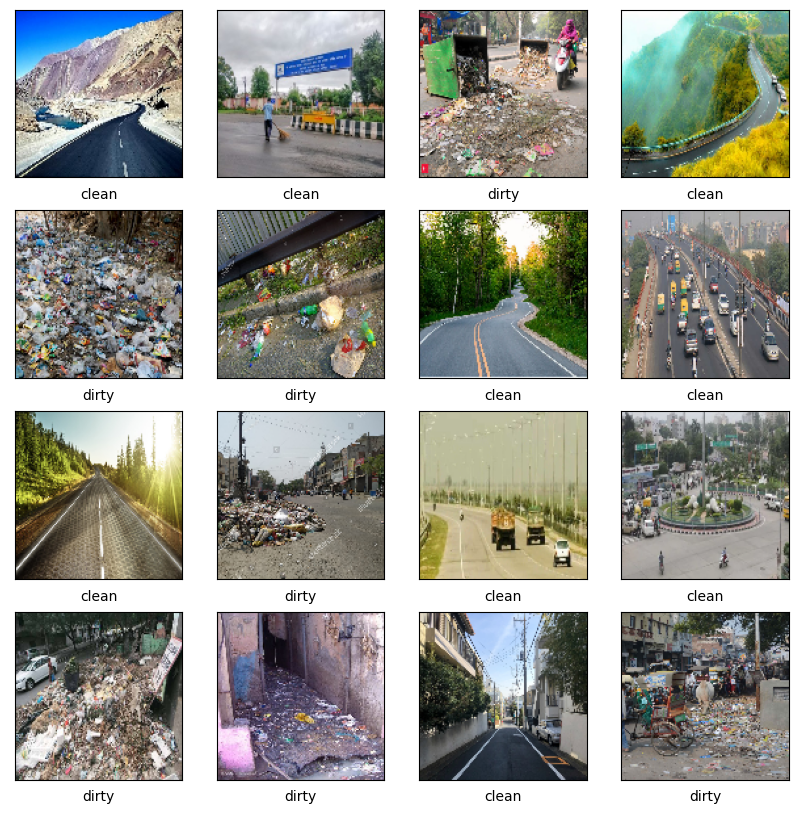

In [3]:
# Display 16 pictures from the dataset
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for x in range(4):
    for y in range(4):
        i = randint(0, len(images))
        
        axs[x][y].imshow(images[i])
        
        # delete x and y ticks and set x label as picture label
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])
        
plt.show()

In [4]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (213, 128, 128, 3)
train labels shape: (213, 2)

validation images shape: (24, 128, 128, 3)
validation labels shape: (24, 2)



In [5]:
# ImageDataGenerator for train images
train_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.3,
                                                                         rotation_range=15,
                                                                         zoom_range=0.3,
                                                                         vertical_flip=True, 
                                                                         horizontal_flip=True)
train_images_generator = train_images_generator.flow(X_train, y=y_train)

# ImageDataGenerator for validation images
validation_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True, 
                                                                              horizontal_flip=True)
validation_images_generator = validation_images_generator.flow(X_val, y=y_val)

In [6]:
def get_model():
    cnn_model = tf.keras.Sequential()

    # Inputs and rescaling
    cnn_model.add(tf.keras.layers.Rescaling(scale=1. / 255, input_shape=(img_size[0], img_size[1], img_size[2])))

    # Convolutional block 1
    cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    # Convolutional block 2
    cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
    cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    # Convolutional block 3
    cnn_model.add(tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same'))
    cnn_model.add(tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    cnn_model.add(tf.keras.layers.GlobalAveragePooling2D())

    # Dense block
    cnn_model.add(tf.keras.layers.Dense(512, activation='relu'))
    cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
    cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
    cnn_model.add(tf.keras.layers.Dense(64, activation='relu'))
    cnn_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))


    cnn_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return cnn_model

In [7]:
min_loss = 10
for seed in np.linspace(1, 257654, 15).astype(int):
    tf.random.set_seed(seed)
    cnn_model = get_model()
    
    loss = cnn_model.fit(train_images_generator, epochs=1, verbose=1, steps_per_epoch=100).history['loss'][0]
    if loss < min_loss:
        min_loss = loss
        best_model = cnn_model
    
print(f'\n\nmin loss: {min_loss}', best_model.summary())

100/100 [==============================] - 4s 8ms/step - loss: 0.7061 - accuracy: 0.5211
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 128)       32896     
                                                                 
 conv2d_27 (Conv2D)          (N

In [8]:
# creating ModelChecpoint callback
checkpoint_callback = ModelCheckpoint('cnn_model/model{epoch:02d}')

In [9]:
history = best_model.fit(train_images_generator, epochs=200, verbose=1, validation_data=validation_images_generator, callbacks=[checkpoint_callback])

Epoch 1/200
7/7 [==============================] - 4s 663ms/step - loss: 0.6964 - accuracy: 0.4789 - val_loss: 0.6932 - val_accuracy: 0.4167
Epoch 2/200
7/7 [==============================] - 3s 528ms/step - loss: 0.6933 - accuracy: 0.5070 - val_loss: 0.6897 - val_accuracy: 0.5833
Epoch 3/200
7/7 [==============================] - 3s 484ms/step - loss: 0.6924 - accuracy: 0.5164 - val_loss: 0.6876 - val_accuracy: 0.5833
Epoch 4/200
7/7 [==============================] - 3s 472ms/step - loss: 0.6937 - accuracy: 0.5164 - val_loss: 0.6858 - val_accuracy: 0.5833
Epoch 5/200
7/7 [==============================] - 3s 479ms/step - loss: 0.6915 - accuracy: 0.5164 - val_loss: 0.6844 - val_accuracy: 0.5833
Epoch 6/200
7/7 [==============================] - 3s 462ms/step - loss: 0.6885 - accuracy: 0.5164 - val_loss: 0.6697 - val_accuracy: 0.5833
Epoch 7/200
7/7 [==============================] - 3s 541ms/step - loss: 0.6737 - accuracy: 0.5493 - val_loss: 0.6004 - val_accuracy: 0.5833
Epoch 8/200
7

In [10]:
# loading best model
cnn_model = tf.keras.models.load_model('/kaggle/working/cnn_model/model188')

In [11]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

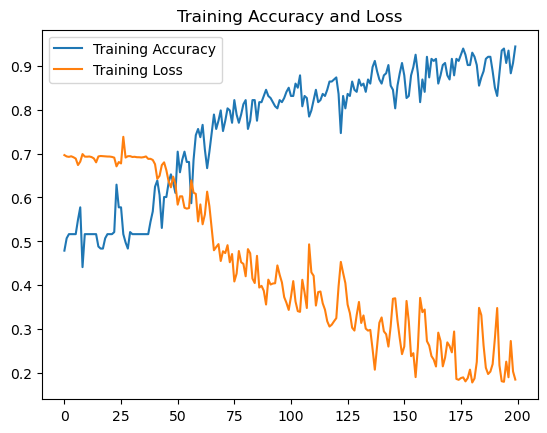

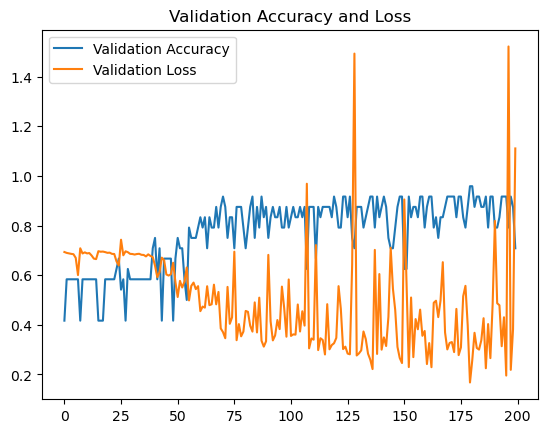

In [12]:
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.legend()
plt.title('Training Accuracy and Loss')

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.show()

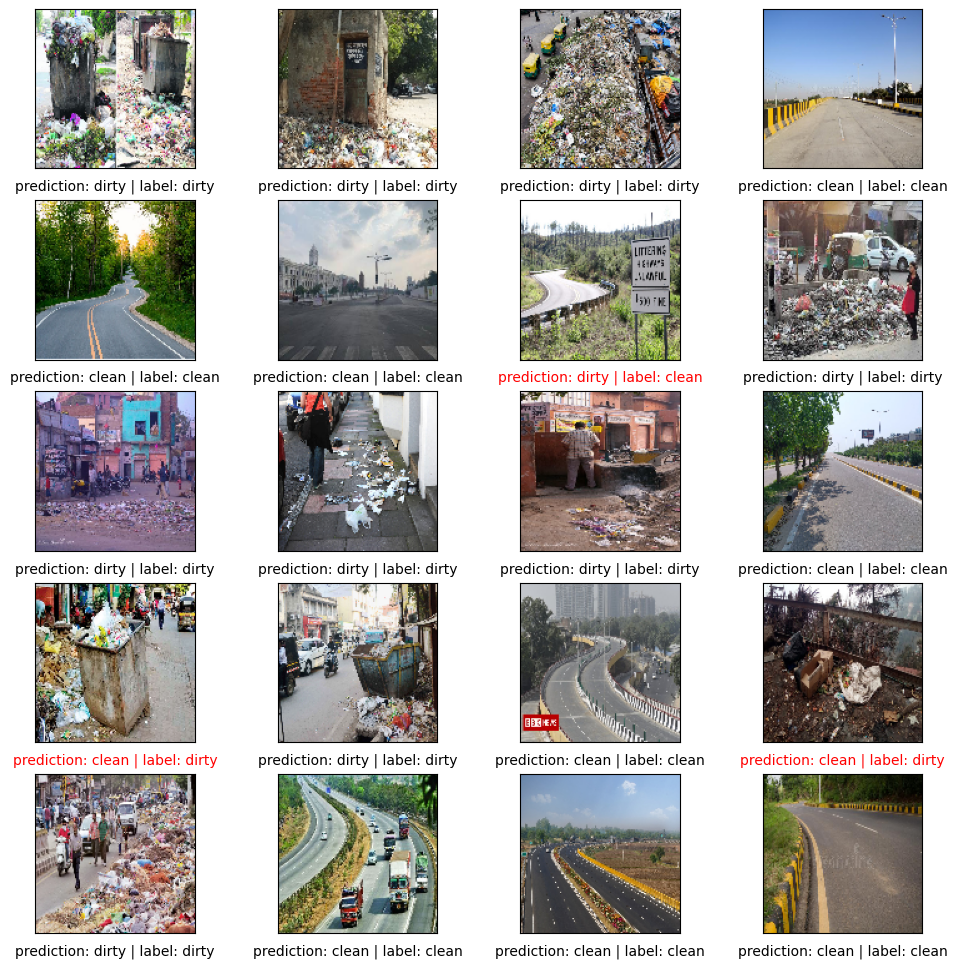

In [13]:
fig, axs = plt.subplots(5, 4, figsize=(12, 12))

i = 0
for x in range(5):
    for y in range(4):
        prediction = cnn_model.predict(X_val[i][None, ...], verbose=0)[0]
        
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        
        if np.argmax(prediction) != np.argmax(y_val[i]):   
            axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}', color='red')
        else:
            axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}')
        
        axs[x][y].imshow(X_val[i])
        
        i += 1
plt.show()